# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("resume/resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skills and education data

If we define patterns for all the skill and education, we will be be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

### 2.1. Education 

**Let's make a new pattern for Education. Here I have just tried to test the patterns. Later I'll save it in a json file and load same as skills.**

In [3]:
import spacy
from spacy.matcher import Matcher #help us recognize patterns
nlp = spacy.load('en_core_web_md')


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# all the patterns
p1 = [{'LOWER': 'phd'}]
p2 = [{'LOWER': 'p'}, {'IS_PUNCT': True}, {'LOWER': 'h'}, {'IS_PUNCT': True}, {'LOWER': 'd'}]
p3 = [{'LOWER': 'masters'}]
p4 = [{'LOWER': 'high'}, {'IS_PUNCT': True}, {'LOWER': 'school'}]
p5 = [{'LOWER': 'highschool'}]
p6 = [{'LOWER': 'bachelors'}]
p7 = [{'LOWER': 'high'}, {'IS_SPACE': True}, {'LOWER': 'school'}]

In [5]:
matcher = Matcher(nlp.vocab)

matcher.add('Education', [p1, p2, p3, p4,p5,p6,p7])

In [6]:
sentence = nlp(u'I am a masters student and aspire to be a phd student\
               and i went to high-school in Nepal. I did my bachelors from University of Northampton.')

In [7]:
match_sentences = matcher(sentence)
print(match_sentences )

for match_id, start, end in match_sentences:
    string_id = nlp.vocab.strings[match_id]  
    span = sentence[start:end]
    #show details
    print(match_id, string_id, start, end, span.text)

[(5427804968328822724, 3, 4), (5427804968328822724, 10, 11), (5427804968328822724, 17, 20), (5427804968328822724, 26, 27)]
5427804968328822724 Education 3 4 masters
5427804968328822724 Education 10 11 phd
5427804968328822724 Education 17 20 high-school
5427804968328822724 Education 26 27 bachelors


In [8]:
#################__seems to work well ___################

**At this point I appended the pattern in the same jsonl file called skills.jsonl and renamed it to be education_skills.jsonl.**

### 2.2. Skills and Education

In [9]:
pattern_path = "resume/education_skills.jsonl"

In [10]:
#nlp.remove_pipe("entity_ruler")

In [11]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [12]:
ruler

In [15]:
doc = nlp("Sagun is a masters student in Thailand and she loves deep learning. She might get a phd.")
doc.ents

(masters, Thailand, deep learning, phd)

In [18]:
# docs = []
# for doc in nlp.pipe(text):
#     print(doc)
# #     matches = matcher(doc)
#     spans = [Span(doc, start, end, label=match_id) for match_id, start, end in matches]
#     print(spans)
#     doc.ents = spans
#     docs.append(doc)

<bound method Matcher.add of <spacy.matcher.matcher.Matcher object at 0x0000019ABB2ABE20>>

## 3. Let's try to extract skills and education from this resume.csv

In [19]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
746,26958533,"ENGINEER Summary Work Ethic,...","<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
2062,25413261,PUBLIC RELATIONS MARKETING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS
151,26046064,GRAPHIC DESIGNER Summary Hi...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
1667,41586420,STORE KEEPER / PRODUCTION CO-ORDINATO...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
60,39081840,HR COORDINATOR Summary To o...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [20]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [21]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         GENERAL MANAGER           Executive Summary    To secure a position with a respected business that will benefit from my organizational and leadership skills. To work with accuracy, efficiency, and friendliness in order to promote customer loyalty, while developing an enthused and goal orien'

In [23]:
preprocessing(random_resume[:300])

'general manager executive summary to secure position respect business benefit organizational leadership skill to work accuracy efficiency friendliness order promote customer loyalty develop enthused goal orien'

In [24]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [25]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
746,26958533,"ENGINEER Summary Work Ethic,...","<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,engineer summary work ethic personal ownership...
2062,25413261,PUBLIC RELATIONS MARKETING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,public relation marketing manager summary driv...
151,26046064,GRAPHIC DESIGNER Summary Hi...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,graphic designer summary highly creative multi...
1667,41586420,STORE KEEPER / PRODUCTION CO-ORDINATO...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,store keeper production co - ordinator summary...
60,39081840,HR COORDINATOR Summary To o...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr coordinator summary to obtain human resourc...


## 4. Let's really extract skills and education!!

In [26]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [27]:
def get_education(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know education now
    
    education = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is EDUCATION, then we append to some list
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
    
    return education

def unique_education(x):
    return list(set(x))

In [28]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
746,26958533,"ENGINEER Summary Work Ethic,...","<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,engineer summary work ethic personal ownership...


In [29]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [38]:
df_resume['Education'] = df_resume.Clean_resume.apply(get_education)
df_resume['Education'] = df_resume.Education.apply(unique_education)

In [37]:
# df_resume.drop(['Education'], axis=1)

In [30]:
df_resume.Skills.iloc[0]

['specification',
 'interaction',
 'software',
 'computer hardware',
 'operating systems',
 'material',
 'diagram',
 'component',
 'stripe',
 'design']

In [39]:
df_resume.Education.iloc[0]

['high school']

In [41]:
df_resume.head(2)

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills,Education
746,26958533,"ENGINEER Summary Work Ethic,...","<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,engineer summary work ethic personal ownership...,"[specification, interaction, software, compute...",[high school]
2062,25413261,PUBLIC RELATIONS MARKETING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,public relation marketing manager summary driv...,"[project management, release, segment, compose...",[]


## 5. Visualization

Which skills is most important in information management?

In [42]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [43]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(43, 7)

In [44]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [45]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [46]:
counting

OrderedDict([('support', 39),
             ('software', 36),
             ('design', 34),
             ('business', 32),
             ('security', 29),
             ('windows', 28),
             ('server', 27),
             ('database', 23),
             ('project management', 21),
             ('documentation', 19)])

<BarContainer object of 10 artists>

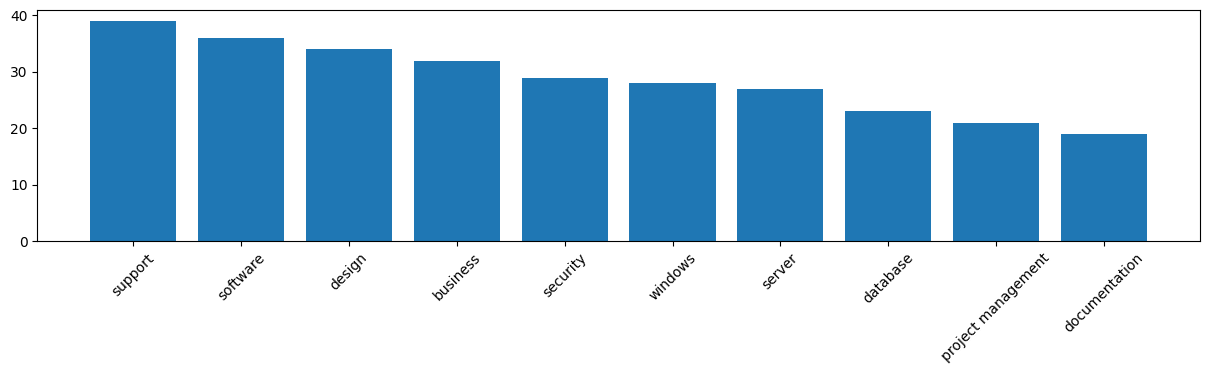

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [49]:
from spacy import displacy

text = df_resume.Clean_resume.iloc[43]

In [50]:
doc = nlp(text)

In [51]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [52]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [53]:
colors = {"EDUCATION": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [62]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("resume/someone_cv.pdf")
page = reader.pages[2] #first page just for demo
text = page.extract_text() 

In [63]:
text = preprocessing(text)

In [64]:
doc = nlp(text)

In [65]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [66]:
colors = {"EDUCATION": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [59]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'computer science', 'ai', 'engineering', 'algorithms', 'deep learning'}


In [60]:
education = []

for ent in doc.ents:
    if ent.label_ == 'EDUCATION':
        education.append(ent.text)
        
print(set(education))

set()


## 8. Try in my own cv

In [75]:
reader = PdfReader("resume/sagun-rupakheti-resume-old.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [76]:
text = preprocessing(text)

In [77]:
doc = nlp(text)

In [78]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [79]:
colors = {"EDUCATION": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

# 9. Model training and save

In [81]:
matcher.

In [80]:
from spacy.tokens import Span

model_text = nlp("Hi my name is Sagun Rupakheti and I am a masters student. I completed my bachelors from University of Northampton. Some of the skills I have include deep learning, python , java , django , machine learning , etc.  ")

In [ ]:
    doc.ents = [Span(doc, 0, 2, label="GADGET")]

In [85]:
# docs = []
# for doc in nlp.pipe(text):
#     print(doc)
#     matches = matcher(doc)
#     spans = [Span(doc, start, end, label=match_id) for match_id, start, end in matches]
#     print(spans)
#     doc.ents = spans
#     docs.append(doc)

In [89]:
# match = Matcher(nlp.vocab)
matcher.add('SKILLS','resume/skills.jsonl')

ValueError: [E948] `Matcher.add` received invalid 'patterns' argument: expected a list, but got: <class 'str'>